# Classification binaire

Ce chapitre est un mixe entre
*  [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff) par François Chollet et
*   "Hands-On Machine Learning with Scikit-Learn and TensorFlow" d'Aurélien Géron


On classifie des critiques de film en deux catégories: "critique positive" et  "critique négative".


In [1]:
%reset -f

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Data

###  IMDB dataset




On télécharge le jeu de donnée IMBD.
* Les data sont des critiques de films
* les labels des entier 0 ou 1 indiquant si la critique est négative ou positive







In [3]:
num_words=10_000

In [4]:
"download the dataset (80MB): it is done only the first time"
from keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_words)

ci-dessus, `num_words=10000` signifie que l'on n'a gardé que les 10000 mots les plus fréquents. Les autres ont été supprimés.

In [5]:
#Il y a 50_000 critiques en tout
len(train_data),len(test_data)

Les data: Chaque élément est une liste d'indices. Chaque indice représente un mot

In [6]:
#les review n'ont pas toute la même longueur
train_data

In [7]:
#affichons les longueurs des 10 premières phrases
for i in range(10):
    print(len(train_data[i]))

***A vous:*** Toutes le listes commencent par 1. Pourquoi ? Le 0 est-il utilisé ?

Voici l'histogramme des longeurs de critiques.

In [8]:
length_sentences=[len(sentence) for sentence in train_data]
val,count=np.unique(length_sentences,return_counts=True)
fig,ax=plt.subplots(figsize=(15,2))
ax.bar(val,count);

Les deux classes sont équilibrées

In [9]:
train_labels

In [10]:
val,count=np.unique(train_labels,return_counts=True)
plt.bar(val,count);

***A vous:*** C'est quoi ce 9999?

In [11]:
max([max(sequence) for sequence in train_data])

***A vous:*** Faite l'histogramme des tokens (=mots traduits en entier) pour voir quels sont les mots les plus fréquents.

Pour les labels, on change simplement de dtype.

In [12]:
y_train=train_labels.astype(np.float32)
y_test=test_labels.astype(np.float32)

### Décodons


Transformons les indices en mots:

In [15]:
# word_index is a dictionary mapping words to an integer index
word_index = imdb.get_word_index()
# We reverse it, mapping integer indices to words
reverse_word_index = {value:key for (key, value) in word_index.items()}
# We decode the review; note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_review = ' '.join([reverse_word_index.get(i - 3, '£') for i in train_data[0]])

In [16]:
decoded_review

***A vous:*** Cette review est clairement positive. Cherchez-en une négative et décodez là $(2\heartsuit)$.

### Préparons les données


Des indices représentant des mots sont des variables qualitatives. Il faut les numériser. Deux techniques existes:

* "vord2vec" il s'agit de représenter chaque mot par un vecteur de grande dimension, de telle manière à ce que les relations sémentiques entre les mots se traduisent en relation vectorielles. Verra cela plus tard.

* "one_hot_encoding": une review du type `[3, 5 ,1]` sera changée un vecteur de taille 10 000 composés de 0 sauf pour les indices 3,5,1 qui seront mis à 1.


In [ ]:
def vectorize_sequences(sequences, dimension):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension), dtype=np.int32)
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1  # set specific indices of results[i] to 1s
    return results

***A vous:*** $(1\heartsuit)$ Est-ce l'ordre des mots a une importance après l'encodage?  Est-ce que la répétition d'un même mot a une importance?



***A vous:*** ($2\heartsuit$) implantez une fonction `vectorize_sequences_with_count` qui prend en compte le nombre d'apparition des mots. Par exemple:

    vectorize_sequences_with_count([[3,1,1,3],[1,2,2]],10)
    
renvera

    [[0 2 0 2 0 0 0 0 0 0]
    [0 1 2 0 0 0 0 0 0 0]]

In [ ]:
x_train = vectorize_sequences(train_data,num_words)
x_test = vectorize_sequences(test_data,num_words)

x_train.shape,x_test.shape

In [ ]:
y_train.shape,y_test.shape

## Model

###  mathématiquement


1/ nous créons un modèle: il s'agissait d'une fonction $x \to model_w(x)$ à valeur dans $[0,1]$, paramétrée par $w$. Cette fonction est la composition de fonctions très simple:

* Fonction linéaire
* Fonction `relu` (pour introduire des non-linéarité)
* Fonction sigmoide (pour fini dans $[0,1]$)


2/ Notre intuition est la suivante: Pour un certain paramètre $w$,  pour tout couple de données $(x,y)$, on aura:
$$
model_w(x)= \hat y\in[0,1]  \qquad \text{ est proche de } \qquad  y \in \{0,1\}
$$

3/ On choisit une 'distance' (une loss) pour mesure l'écart entre $\hat y$ et  $y$, c'est la crossentropy **binaire**:
$$
\mathtt{BCE}(y, \hat y ) :=  - y \log (\hat y )   -  (1-y) \log(1-\hat y)
$$
Que l'on somme sur toutes les observations
$$
loss_w=\sum_{i \in Batch} \mathtt{BCE} (y_i, \hat y_i )= \sum_{i \in Batch} \mathtt{BCE} (y_i, model_w(x_i) )
$$
On demande à l'algo d'optimisation de trouver le $\hat w$ qui minimise cette loss sur plein de batchs.

4/ La fonction $x\to model_{\hat w} (x)$ sera un bon outil pour prédire des nouveaux input $x$.






### Construction

On va construire un réseau dense:

In [ ]:
class ModelClassif(tf.keras.Model):

    def __init__(self):
        super().__init__()
        #on précise la dimension de l'input, mais ce n'est pas obligatoire!
        self.layer1=tf.keras.layers.Dense(16, activation='relu', input_shape=(10000,))
        self.layer2=tf.keras.layers.Dense(20, activation='relu')
        self.layer3=tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self,X):
        Y=self.layer1(X)      #=   relu(X@W1 + b1)
        Y=self.layer2(Y)      #=   relu(Y@W2 + b2)
        return self.layer3(Y) #=sigmoid(Y@W3 + b3)


In [ ]:
model=ModelClassif()
res=model(tf.random.uniform([3,10000]))
res.shape

***A vous:*** Quels sont les shapes des différentes trainable_variables ? Vérifiez en excécutant le code suivant:

    for tens in model.trainable_variables:
        print(tens.shape)

Le modèle précédent peut aussi être définit en plus court:


    model = keras.models.Sequential()
    model.add(keras.layers.Dense(16, activation='relu', input_shape=(10000,)))
    model.add(keras.layers.Dense(20, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))

On peut aussi accédé au layers individuellement, et récupérer leur caractéristiques:

    for index in [0,1,2]:
        weights,bias=model.layers[index].get_weights()
        print(f"layer {index}")
        print("weights.shape:",weights.shape)
        print("bias.shape:",bias.shape)
        print()

In [ ]:
model.summary()


***Remarque:*** Pour chaque couche cachée: le nombre de neurone (=la dimension=nb units) correspond à "combien de degré de liberté on donne au réseau de neurone pour se représenter le problème". Avec beaucoup de liberté, le réseau peut se faire des représentations plus complexe. Mais cela requiert plus de calcul, et il peut apprendre des motifs (=pattern) superflus: propre au donnée train et donc non généralisable.


### Récréation: dessinons un petit modèle

Voici un réseau plus modeste.

    model = models.Sequential()
    model.add(layers.Dense(8, activation='relu', input_shape=(16,)))
    model.add(layers.Dense(4, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
Effectuons une représentation graphique: Chaque flèche represente un paramètre.

***A vous:*** Que symbolisent les fèches noires ($1\heartsuit$)? Combien ce réseau a de paramètre ($1\heartsuit$)?

In [ ]:
nb_input=16
nb_hidden1=8
nb_hidden2=4
input_points= [(1,i) for i in range(nb_input)]
hidden1_points=[(2,2*i+0.5) for i in range(nb_hidden1)]
hidden2_points=[(3,4*i+1) for i in range(nb_hidden2)]


for x,y in input_points:
  for a,b in hidden1_points:
    plt.plot([x,a],[y,b])


for a,b in hidden1_points:
  plt.plot([1.1,a],[16,b],"k")
  for x,y in hidden2_points:
    plt.plot([x,a],[y,b])


for x,y in hidden2_points:
  plt.plot([2.1,x],[16,y],"k")
  plt.plot([x,4],[y,8])


plt.plot([3.1,4],[16,8],"k");

## Tout pour l'entrainement

### Distributeur de batch

In [ ]:
"""  distributeur de donnée par batch.   """
def oneEpoch(X_all,Y_all,batch_size):

    nb_batches=len(X_all)//batch_size

    shuffle_index=np.random.permutation(len(X_all))
    X_all_shuffle=X_all[shuffle_index]
    Y_all_shuffle=Y_all[shuffle_index]

    for i in range(nb_batches):
        yield X_all_shuffle[i*batch_size:(i+1)*batch_size],Y_all_shuffle[i*batch_size:(i+1)*batch_size]

In [ ]:
for x,y in oneEpoch(x_train,y_train,256):
    print(x_train.shape)
    print(y_train.shape)
    break

### Loss et accuracy

In [ ]:
def binary_cross_entropy(y_true,y_pred):
    epsilon=1e-6
    return tf.reduce_mean(-y_true*tf.math.log(y_pred+epsilon)-(1-y_true)*tf.math.log((1-y_pred)+epsilon))

In [ ]:
y_true=np.array([[1.,0]])
y_pred=np.array([[0.9,0.1]])
print(y_true)

In [ ]:
binary_cross_entropy(y_true,y_pred).numpy()

Cette fonction est déjà codée dans keras, sauf qu'elle ne fait pas la moyenne:

In [ ]:
keras.losses.binary_crossentropy(y_true,y_pred).numpy()

In [ ]:
def accuracy(y_true,y_pred):
    y_pred=np.round(y_pred).astype(bool)
    y_true=y_true.astype(bool)
    return np.mean(y_pred==y_true)

accuracy(y_true,y_pred)

### Agent

In [ ]:
class Agent:


    def __init__(self,model,learning_rate,X,Y,batch_size,alpha=0,ridge_vs_lasso=True):
        self.loss_fn = binary_cross_entropy
        self.model = model
        self.batch_size=batch_size
        self.alpha=alpha
        self.ridge_vs_lasso=ridge_vs_lasso

        nb_data_train=int(len(X)*0.8)
        self.X_train=X[:nb_data_train]
        self.Y_train=Y[:nb_data_train]
        self.X_val=X[nb_data_train:]
        self.Y_val=Y[nb_data_train:]

        self.optimizer = tf.keras.optimizers.Adam(learning_rate)
        self.losses=[]
        self.val_steps=[]
        self.val_losses=[]
        self.step_count=-1


    def compute_penalization_term(self):
        all_kernels=[]

        if self.ridge_vs_lasso:
            fn = lambda kernel : kernel**2
        else:
            fn = lambda kernel : tf.abs(kernel)


        for tv in self.model.trainable_variables:
            if len(tv.shape)==2:
                all_kernels.append( tf.reshape(fn(tv),[-1]) )


        return self.alpha * tf.reduce_sum(tf.concat(all_kernels,axis=0))



    @tf.function
    def train_step(self,x,y):
        with tf.GradientTape() as tape:
            y_pred = self.model(x,training=True)
            loss = self.loss_fn(y[:,None],y_pred)
            if self.alpha>0:
                loss+=self.compute_penalization_term()


        gradients=tape.gradient(loss,self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients,self.model.trainable_variables,))
        return loss


    @tf.function
    def val_step(self,x,y):
        y_pred = self.model(x,training=False)
        loss = self.loss_fn(y[:,None],y_pred) #attention, ordre inversé par rapport à torch
        return loss


    def train(self,nb_epochs):
        for _ in range(nb_epochs):
            for x,y in oneEpoch(self.X_train,self.Y_train,self.batch_size):
                self.step_count+=1
                loss=self.train_step(x,y)
                self.losses.append(loss.numpy())

            val_loss=self.val_step(self.X_val,self.Y_val).numpy()
            self.val_losses.append(val_loss)

            if val_loss<=np.min(self.val_losses):
                print(f"⬊{val_loss:.2f}",end="")
                #get_weights() effectue une copie. Pas besoin d'appeler copy.deepcopy comme en torch
                self.best_weights=self.model.get_weights()
            else:
                print("⬈",end="")

            self.val_steps.append(self.step_count)

    def set_model_at_best(self):
        self.model.set_weights(self.best_weights)


def test():
    learning_rate=1e-3
    batch_size=256
    model=ModelClassif()
    agent=Agent(model,learning_rate,x_train,y_train,batch_size,alpha=0.1,ridge_vs_lasso=False)
    agent.train(1)
test()


## Entrainement

### Premier entrainement

In [ ]:
learning_rate=1e-3
batch_size=256
agent=Agent(ModelClassif(),learning_rate,x_train,y_train,batch_size)

In [ ]:
agent.train(10)

In [ ]:
plt.plot(agent.losses,label="loss")
plt.plot(agent.val_steps,agent.val_losses,".",label="val_loss")
plt.legend();


* la loss décroit sans arrêt: notre optimizer fonctionne.
* Mais la val_loss remonte après 2 ou 3 epochs

C'est typique du sur-apprentissage (over-fitting): L'optimizer apprend des motifs spécifique au donnée train et donc qui ne se généralise pas au données `val`, `test` et au futur données entrantes.





### Evaluons le modèle sur les données tests

In [ ]:
binary_cross_entropy(y_test[:,None],agent.model(x_test))

In [ ]:
accuracy(y_test[:,None],agent.model(x_test))

In [ ]:
agent.set_model_at_best()
binary_cross_entropy(y_test[:,None],agent.model(x_test))

In [ ]:
accuracy(y_test[:,None],agent.model(x_test))

88% d'accuracy: pas mal. Mais les approches de l'"état de l'art" (state-of-the-art) font du 95%.

***A vous:*** $(2\heartsuit)$  Pour le protocole que l'on a utilisé:  était-il vraiment nécessaire d'avoir des données `validation` et `test` distinctes?

### Annalyse de prédiction


In [ ]:
hat_y_test_proba=agent.model(x_test).numpy()
hat_y_test=(hat_y_test_proba>0.5).astype(int)
print("proba:")
print(hat_y_test_proba[:10])
print("classe estimée")
print(hat_y_test[:10])
print("vraie classe")
print(y_test[:10])

***A vous:*** Trouvez une critique mal classifiée. Décodez la en anglais.

***A vous:*** Retrouver le chiffre de 88% d'accuracy à partir des 2 vecteurs précédents.

In [ ]:
fig,(ax0,ax1)=plt.subplots(1,2,figsize=(8,2))
ax0.hist(hat_y_test_proba[y_test==0],bins=40,edgecolor="k")
ax1.hist(hat_y_test_proba[y_test==1],bins=40,edgecolor="k");

On peut voir que le réseau est assez confiant en ses prédictions: la majorité des probas est proche de 0 ou de 1.


###Exo: Faites vos propres expérimentation

* $(3\heartsuit)$ essayez en vectorisant les séquences avec `vectorize_sequences_with_count`
* $(3\heartsuit)$ on a essayé 2 couches cachées. Testez avec 1 ou 3.
* $(3\heartsuit)$ Changez le nombre de neurone par couches (number of units)
* $(3\heartsuit)$ Essayez la loss `mse`.
* $(3\heartsuit)$ Essayez des fonctions d'activation `tanh` dans les couches intermédiaires.

## Lutter contre le sur-apprentissage







### Réduire la taille du modèle

In [ ]:
smaller_model = keras.models.Sequential()
smaller_model.add(keras.layers.Dense(4, activation='relu', input_shape=(10000,)))
smaller_model.add(keras.layers.Dense(4, activation='relu'))
smaller_model.add(keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
agent_smaller=Agent(smaller_model,learning_rate,x_train,y_train,batch_size)
agent_smaller.train(10)

In [ ]:
plt.plot(agent.val_steps,agent.val_losses,".-",label="original")
plt.plot(agent_smaller.val_steps,agent_smaller.val_losses,".-",label="smaller")
plt.legend();

Le petit modèle comment à sur-ajuster plus tard que le gros. Et ses performance se dégradent plus lentement.

Essayons maintenant avec un modèle de plus grosse capacité.

In [ ]:
bigger_model = keras.models.Sequential()
bigger_model.add(keras.layers.Dense(512, activation='relu'))
bigger_model.add(keras.layers.Dense(512, activation='relu'))
bigger_model.add(keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
agent_bigger=Agent(bigger_model,learning_rate,x_train,y_train,batch_size)
agent_bigger.train(10)

In [ ]:
plt.plot(agent.val_steps,agent.val_losses,".-",label="original")
plt.plot(agent_smaller.val_steps,agent_smaller.val_losses,".-",label="smaller")
plt.plot(agent_bigger.val_steps,agent_bigger.val_losses,".-",label="bigger")
plt.legend();

Le gros modèle sur-ajuste plus sévèrement. Sa loss de validation est plus bruités.

Quand à sa loss de train:

### Pénaliser




  _Occam's Razor_ principle: étant donnée 2 explications valables,  la meilleure est la plus simple.
   

![toot](https://drive.google.com/uc?export=view&id=19UwF49NvDNwl7NlyTkn_5WZl1bF9AL5P)


Cela s'applique aussi au modèles de machine learning: Un modèle simple dans ce contexte, est celui dont la distribution des paramètre la moins d'entropy. Pour  régulariser on peut forcer les poids de prendre des petites valeurs, ce qui rend la distribution des poids plus régulière. C'est la   "weight regularization" ou "pénalisation des poids".

Pour ce faire on ajouter un terme à la loss, qui est grand quand les poids sont grands en valeur absolue.
Les deux techniques principales sont:

* Régularisation L1 ou lasso:
$$
loss_\alpha= loss + \alpha \sum_i |w_i|
$$
* Régularisation L2 ou ridge:
$$
loss_\alpha= loss +\alpha \sum_i (w_i)^2
$$
La somme étant faite sur tous les poids $w_i$ appartenant à un 'kernel' (une matrice).


Remarquons qu'on ne pénalise pas en général les biais.

Le travail des biais est de recentrer les données autour de zéro à chaque couche (0 c'est la partie intéressante des fonctions d'activations): il faut donc laisser les bias faire leur travail sans les pénaliser.

***A vous:*** La pénalisation Ridge (ou l2) est aussi appelée weight decay. En voici la raison.

Considérons la fonction loss non-régularisée $loss(w)$. La descente de gradient (toute simple) correspond à changer les paramètres selon la règle suivante:
$$
w_i \leftarrow w_i - \ell \, \frac{\partial loss}{\partial w_i}
$$
où $\ell$ est le learning rate.  Considérons la loss régularisée:
$$
loss_{\alpha}(w)=loss(w) + \alpha \sum_i w_i^2
$$. Comment $(1\heartsuit)$ s'écrit la descente de gradient maintenant ? Cela justifie le fait que le coefficient $\alpha$, dans le cadre ridge, soit parfois appelé `loss_decay`.






***Remarques:*** on doit bien ajuster $\alpha$:

* $\alpha$ trop petit la pénalisation est inefficace, $\alpha$ trop grand le modèle n'apprend plus rien (tous les poids vont vers 0).

*  Typiquement, $\alpha$ peut-être choisi par cross validation, en essayant successivement $ 0.1,0.01,0.001,0.0001$ et en comparant les courbes val-loss et loss.


In [ ]:
agent_ridge=Agent(ModelClassif(),learning_rate,x_train,y_train,batch_size,alpha=0.001,ridge_vs_lasso=False)
agent_ridge.train(10)

In [ ]:
plt.plot(agent.val_steps,agent.val_losses,".-",label="original")
plt.plot(agent_ridge.val_steps,agent_ridge.val_losses,".-",label="ridge")
plt.legend();

On voit ci-dessus que le modèle pénalisé est plus résistant à l'over-fitting.



Observons la distribution des poids:

In [ ]:
layer_index=0

l2_weights, l2_biases = agent_ridge.model.layers[layer_index].get_weights()
original_weights, original_biases = agent.model.layers[layer_index].get_weights()

fig,axs=plt.subplots(2,2,sharex=True,figsize=(10,10))

bins=np.linspace(-0.1,0.1,40)

axs[0,0].hist(l2_weights.reshape(-1),bins=bins)
axs[0,0].set_title("weights regul")
axs[0,0].set_xlim(-0.1,0.1)
axs[0,1].hist(l2_biases.reshape(-1),bins=bins)
axs[0,1].set_title("bias regul")
axs[0,1].set_xlim(-0.1,0.1)

axs[1,0].hist(original_weights.reshape(-1),bins=bins)
axs[1,0].set_title("weights")
axs[1,1].hist(original_biases.reshape(-1),bins=bins);
axs[1,1].set_title("bias")

***A vous:*** L'option `ridge_vs_lasso`dans le programme précédent permet de passer d'une pénalisation à l'autre. Faites tourner le programme avec l'autre option, observez l'histogramme des poids.


La régularisation l1 est souvent utiliser dans un modèle linéaire (=1 couche) dans le but de sélectionner des variables: on regarde quelles sont les variables associées à des paramètres qui ne s'annuelent pas: ce sont les variables importantes.


On peut mélanger les deux pénalisation, on parle alors "d'elastic-net".


### Recap

Pour récapituler, pour combattre le sur-apprentissage on peut:

* collecter plus de donnée, ou les enrichir
* réduire la capacité du modèle (le nombre de paramètre=poids)
* pénaliser les poids
* ajouter du dropout (on verra cela l'an prochain


Des chercheurs ont aussi montré qu'une moindre précision dans les flotants (float32 au lieu de float64), introduisait un flou qui limiter le sur-apprentissage. On va même plus loin en randomisant les paramétres: c'est la théorie des réseaux de neurones bayesiens.


Cependant, il arrive que l'on cherche à faire du sur-apprentissage:

* Quand on veut tester si un modèle est assez gros, on peut vérifier qu'il a la capicité de sur-apprendre
* Quand on veut interpoler des données non-bruitées: données uniques (train=test).

Alors tout est permis pour faire diminuer au maximum la loss-train.


## Scores

Résumons:
* A partir des `x_test`, notre modèle prédit des proba `hat_y_test_proba`
* On prend un seuil de 0.5 puis on décide que `hat_y_test=(hat_y_test_proba>0.5)`
* On va maintenant mesurer de différentes façon l'écart entre  `hat_y_test` et le vrai `y_test`


En classification binaire, l'une des deux classes est appelée positive l'autre négative.

Traditionnellement, la classe positive est celle qui nous intéresse le plus ex: présence d'une maladie. Elle est souvent minoritaire. Ici, on décide que la classe positive c'est la classe 1: celle des critiques positives de film.



In [ ]:
print(hat_y_test_proba)
print(hat_y_test)
print(y_test)

###  Matrice de confusion

* les lignes indiques les vrai classes
* les colonnes les prédiction
* ex: l'intersection entre la première ligne et la première colonne indique le nombre de négatif bien classé.


In [ ]:
import sklearn.metrics
C=sklearn.metrics.confusion_matrix(y_test, hat_y_test)
"a dataframe just for presentation"
C_df=pd.DataFrame(data=C,columns=[ r"^-",r"^+"],index=[r"-",r"+"])
C_df

### Vrais/Faux positif/Negatif

On donne des noms à chacune des casses de la matrice de confusion:
$$
\begin{array}{c|cc}
& \hat - & \hat + \\
\hline
- & TN & FP \\
+ & FN &  TP   
\end{array}
$$

In [ ]:
TN=C[0,0]
FN=C[1,0]
FP=C[0,1]
TP=C[1,1];

***A vous:*** Faites les calculs demandé ci-dessous sans utiliser l'ordinateur:
* Indiquez  $(1\heartsuit)$  quel serait le résultat de  `confusion_matrix(y_test, y_test)`?  
* Indiquez  $(2\heartsuit)$  quel serait le résultat de  `confusion_matrix(y_test, y_rand)` avec `y_rand` un vecteur aléatoire de 0 et de 1?

### Précision/rappel


$$
\begin{align}
\text{precision} & =\frac{TP}{TP+FP}=  \frac{+\cap \hat +}{\hat +} = \text{accuracy of the positive predictions}\\
\text{recall} & =\frac{TP}{TP+FN} = \frac{+\cap \hat +}{ +} = \text{ratio of positive instances that are correctly detected}
\end{align}
$$

* Précision proche de 1: la plupart des prédictions son bonnes.
* Rappel proche de 1: on détecte la plupart des positifs

Si notre modèle détecte une maladie, il faut avoir un bon rappel. Surtout si on peut ensuite faire des examen supplémentaire pour éliminer les faux positifs.


In [ ]:
print("precision_score: %.2f"%(TP/(TP+FP)))
print("recall_score: %.2f"%(TP/(TP+FN)))

### F1 score

C'est la moyenne harmonique de la précision et du rappel:
$$
F_1= \frac{2}{\frac{1}{\text{precision}} + \frac{1}{\text{recall}}}
$$
 Le modèle a un bon F1-score quand précision et rappel sont tous les deux grands.






##  Changeons le seuil

On n'est pas obligé de prendre 0.5 comme seuil. Typiquement, on peut favoriser la classe minoritaire.

Avant de choisir un seuil, il est intéressant de regarder des courbes qui présente les résultats pour tous les seuils possibles.


Attention, certains modèle (ex: le gradient-stochastique de `sklearn`) ne renvoient pas des probas, mais simplement un score réel ex: entre -7000 et +9000. Mais le principe est le même: plus le score est grand et plus il faut classe la ligne dans les positifs. Ce qui suit reste valide: remplacer simplement l'intervalle [0,1] par l'intervalle [-7000,+9000].  



### Precision/Recall Tradeoff


In [ ]:
precisions, recalls, thresholds = sklearn.metrics.precision_recall_curve(y_test, hat_y_test_proba)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="lower center", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([0, 1])

*   seuil  grand $\Rightarrow$ $\hat +$ petit $\Rightarrow$ grande précision et petit rappel.
*  Cas extrème:  Seuil $=1$  $\Rightarrow$ $\hat + = \emptyset$  $\Rightarrow$
$$
\begin{align}
\text{precision} & =  \frac{+\cap \hat +}{\hat +} = \frac 0 0 =  1 \\
\text{rappel}    & =  \frac{+\cap \hat +}{+}  = 0
\end{align}
$$


* Retenez: avec un grand seuil, on est très exigent pour classer les données +, donc je ne classe que des vrais +, donc grande précision.  




*   seuil  petit $\Rightarrow$ $\hat +$ grand $\Rightarrow$ petite précision et grand rappel.
*   Cas extrème:  Seuil=0 $\Rightarrow$ $\hat + = all$  $\Rightarrow$
$$
\begin{align}
\text{precision} & = \frac{+\cap \hat +}{\hat +} =  \frac{+}{all} = (\text{ ici } \frac 1 2 )  \\
\text{rappel}    & =  \frac{+\cap \hat +}{+}  =\frac{+}{+} =  1
\end{align}
$$
* retenez: avec un petit seuil,  on classe plein de donnée +, on ne va pas en rater beaucoup: grand rappel.







Vous pouvez choisir votre seuil en fonction de cette courbe, ou de la suivante:

In [ ]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)

Sur cette courbe, je choisirais le seuil qui correspond à un recall de 0.8: juste avant sa chutte.

### La courbe ROC

ROC signifie receiver operating characteristic (ROC). C'est une coubr très utilisée pour observer l'effet du seuillage:


* TPR = True Positive Rate = recall = ratio of positive instances that are correctly classified=
$$
\frac{+\cap \hat +}{ +}
$$
*  FPR = False Positive Rate =  ratio of negative instances that are incorrectly classified as positive =
$$
\frac{-\cap \hat +}{ - }
$$



In [ ]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, hat_y_test_proba)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)


Le score AUC (area under the curve) c'est l'aire sous la courbe ROC. Au mieux elle vaut 1. Au pire 0.5.


In [ ]:
sklearn.metrics.roc_auc_score(y_test, hat_y_test_proba)

###  courbe ROC à la main  $\flat$

Pour le plaisir, programmons notre propre courbe ROC.

In [ ]:
def TPR_FPR(threshold: float, y: np.ndarray, scores: np.ndarray):
    """
    Cette fonction renvoie:
        * le taux de vrais positifs : fractions des positifs qui sont classés positifs
        * le taux de faux  positifs : fractions des négatifs qui sont classés positifs.
    """


    """ on classe positifs (=en 1) les individus dont la proba estimée d'être 1 est > threshold   """
    y_hat = (scores >= threshold).astype(np.int)

    """Calculons les indexes des positifs et des négatifs. """
    index_P = (y == 1)
    index_N = (y == 0)


    TPR = np.sum(y_hat[index_P] == 1) / np.sum(index_P)
    FPR = np.sum(y_hat[index_N] == 1) / np.sum(index_N)

    return TPR, FPR

Effectuons un programme test. On se donne deux classes: la classe 0=negatif, et 1=positif. On suppose que l'on a des probabilité et des classes comme ceci:

In [ ]:
a=[
    [0.49,0.51],
    [0.3,0.7],
    [0.1,0.9],
    [0.6,0.4],
    [0.55,0.45],
    [0.2,0.8]
]
probas=np.array(a)
print("probas:\n",probas)
true_cl=np.array([1,1,1,0,1,0])
print("true_cl:\n",true_cl)

Avec un seuil  `threshold=0.5` on trouve:

In [ ]:
estimated_cl=(probas>0.5).astype(np.int)[:,1]
print("estimated_cl:\n",estimated_cl)

Ainsi à l'oeil on voit que

*  TPR = 3/4
*  FPR = 1/2

In [ ]:
TPR_FPR(threshold=0.5, y=true_cl, scores=probas[:,1])

***A vous:*** Blindez la fonction `TPR_FPR`:

* $(2\heartsuit)$ Il y a un problème mathématique si on rentre `y=np.zeros(6)`.
* $(2\heartsuit)$ Il y a un problème  si l'utilisateur (quel couillon!) rentre `y=[1,1,1,0,1,0]` au lieu de  `y=np.array([1,1,1,0,1,0])` (le `==` ne fonctionne pas pareil sur les listes et sur les tenseur numpy).

Remarque: l'instruction de typage  dans l'argument de la fonction `y: np.ndarray` fournis uniquement un warning si l'utilisateur a une IDE qui vérifie le typage. Ce n'est pas le cas pour l'instant sur les notebook.

In [ ]:
thresholds=np.linspace(np.min(hat_y_test_proba),np.max(hat_y_test_proba),100)
a=[]
b=[]
for th in thresholds:
    fpr1, tpr1 =TPR_FPR(th,y_test, hat_y_test_proba)
    a.append(fpr1)
    b.append(tpr1)
print(a)

plt.plot(b,a);

### Comparons avec les forêts aléatoires

On detaillera dans un prochain TP comment marche les forêts aléatoires.

Les arbres aléatoires de `sklearn` renvoie une proba avec la méthode méthode `predict_proba` (et pas `predict`)


In [ ]:
import sklearn.ensemble
forest_clf = sklearn.ensemble.RandomForestClassifier(random_state=42)
forest_clf.fit(x_train,y_train)
hat_y_test_proba_forest=forest_clf.predict_proba(x_test)

print(hat_y_test_proba_forest[:10,:])

But to plot a ROC curve, you need one scores, not two probabilities. A simple solution is to use the positive class’s probability as the score:

In [ ]:
y_scores_forest = hat_y_test_proba_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = sklearn.metrics.roc_curve(y_test,hat_y_test_proba_forest[:,1])
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plot_roc_curve(fpr, tpr, "Neural network")

plt.legend(loc="lower right", fontsize=16);

La forêt aléatoire est  moins bien.

* on n'a pas du tout réglé les hyper-paramètres de cette forêt.
*  les données textuelles ne sont pas favorable aux forêts aléatoires

## Utilisons l'embeding

### Principe

Nous allons maintenant utiliser une technique plus avancé: l'embeding: Chaque entier est associé à un vecteur de grande dimension; ces vecteurs étant des trainable-variables: les relations sémentiques entre mot vont, lors de l'apprentissage,  se traduire par des relations vectorielles.


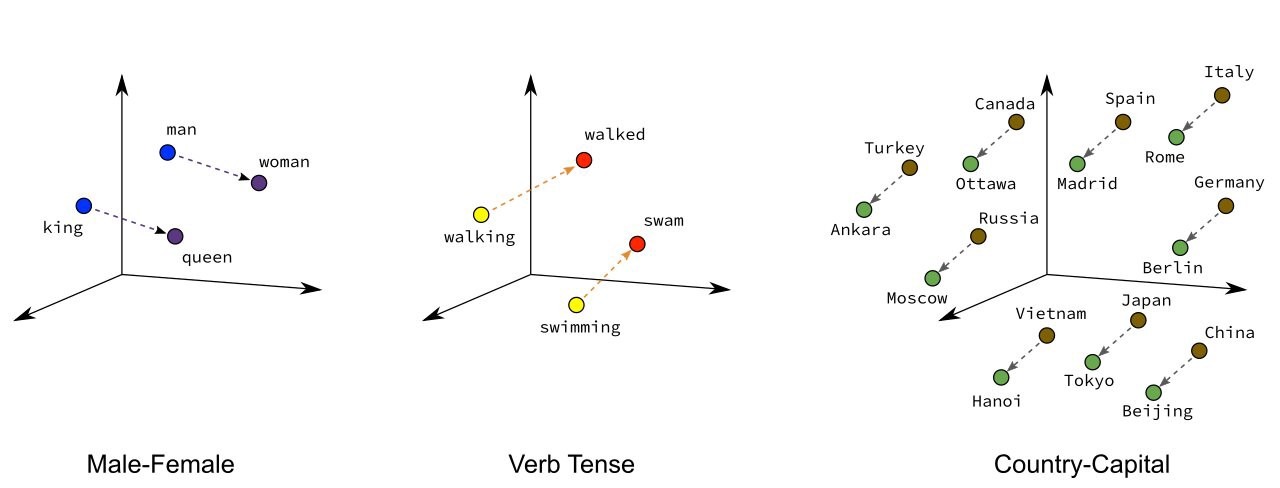

### Exemple petit

In [ ]:
import pandas as pd
vocab_size=10 #le nombre de mots possibles
embed_dim=3    #la dimension de chaque vecteur
embeding_layer=tf.keras.layers.Embedding(vocab_size, embed_dim)
input=tf.constant([1,0,2,2,1,8,8])
res=embeding_layer(input)
pd.DataFrame(index=input,data=res.numpy())

In [ ]:
embeding_layer.trainable_variables

### Ajoutons du padding

In [ ]:
train_data

In [ ]:
def make_full_matrix(data,max_sentence_length=600):
    nb=len(data)
    res=np.zeros([nb,max_sentence_length],dtype=np.int32)
    for i,sentence in enumerate(data):
        keep=min(len(sentence),max_sentence_length)
        res[i,:keep]=sentence[:keep]
    return res

In [ ]:
x_train2=make_full_matrix(train_data)
x_test2=make_full_matrix(test_data)

In [ ]:
x_train2.shape

In [ ]:
plt.imshow(x_train2[:500]>0);

### Testons l'embedind sur un batch

In [ ]:
batch=x_train2[:5]
batch.shape

In [ ]:
embed_dim=32
embeding_layer=tf.keras.layers.Embedding(10_000, embed_dim)
batch_embeded=embeding_layer(batch)
batch_embeded.shape

In [ ]:
nb=5
fig,axs=plt.subplots(nb,1,figsize=(10,nb),sharex="all")
for i in range(nb):
    axs[i].plot(batch_embeded[0,:,i])

In [ ]:
nb=5
fig,axs=plt.subplots(nb,1,figsize=(10,nb),sharex="all")
for i in range(nb):
    axs[i].plot(batch_embeded[1,:,i])

***A vous:*** Pourquoi les séries deviennent constante au bout d'un moment?

### Modèle

In [ ]:
class ModelClassifEmbed(tf.keras.Model):

    def __init__(self):
        super().__init__()
        #on précise la dimension de l'input, mais ce n'est pas obligatoire!
        self.embed_dim=32
        self.vocab_size=num_words
        self.embeding_layer=tf.keras.layers.Embedding(self.vocab_size, self.embed_dim)

        self.layer0=tf.keras.layers.Dense(32, activation='relu')
        self.layer1=tf.keras.layers.Dense(32, activation='relu')
        self.layer2=tf.keras.layers.Dense(32, activation='relu')
        self.layer3=tf.keras.layers.Dense(1, activation='sigmoid')

        rate=0.3
        self.drop_layer0=tf.keras.layers.Dropout(rate)
        self.drop_layer1=tf.keras.layers.Dropout(rate)
        self.drop_layer2=tf.keras.layers.Dropout(rate)
        self.drop_layer3=tf.keras.layers.Dropout(rate)



    def call(self,X,training):
        batch_size,nb_word=X.shape

        X=self.embeding_layer(X) #(batch_size,nb_word,embed_dim)
        X=tf.reshape(X,[batch_size,nb_word*self.embed_dim])

        X=self.drop_layer0(X,training)
        X=self.layer0(X)
        X=self.drop_layer1(X,training)
        X=self.layer1(X)
        X=self.drop_layer2(X,training)
        X=self.layer2(X)
        X=self.drop_layer3(X,training)
        return self.layer3(X)

### Entrainement

In [ ]:
learning_rate=5e-4
batch_size=512
agent=Agent(ModelClassifEmbed(),learning_rate,x_train2,y_train,batch_size)

In [ ]:
agent.train(10)

J'ai essayé plein de variantes, malheureusement, sans passer en dessous d'une loss de 0.32

In [ ]:
plt.plot(agent.losses,label="loss")
plt.plot(agent.val_steps,agent.val_losses,".",label="val_loss")
plt.legend();

In [ ]:
agent.set_model_at_best()
y_pred=agent.model(x_test2,training=False)
binary_cross_entropy(y_test[:,None],y_pred)

In [ ]:
accuracy(y_test[:,None],y_pred)